In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import math
import pathlib
import cv2 as cv
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [2]:
#torch.cuda.get_device_name(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class load_data(Dataset):
    def __init__(self, img_dir, gt_name):
        self.img_dir = img_dir
        self.gt_name = gt_name
        self.img_data_all , self.bboxes_all, self.gt_classes_all = self.get_data()
        #print(len(img_data_all) , len(bboxes_all), len(gt_classes_all))
    def __getitem__(self,idx):
        return self.img_data_all[idx].to(device) , self.bboxes_all[idx].to(device), self.gt_classes_all[idx].to(device)
    def __len__(self):
        return self.dataset_size
    def get_data(self):
        gt_data = pd.read_csv('../train/gt.txt', delimiter = ';', header = None)
        data = {}
        for i,row in gt_data.iterrows():
            str = '../train/images_all/' + row[0]
            l = list([row[1], row[2], row[3], row[4]])
            data.setdefault(str, []).append(l)
        classes = {}
        #print(len(data))
        for i,row in gt_data.iterrows():
            str = '../train/images_all/' + row[0]
            classes.setdefault(str, []).append(row[5])
        data_dir = pathlib.Path(self.img_dir)
        bboxes_all = []
        gt_classes = []
        img_data_all = []
        i = 0
        for image , bboxes in data.items():
            i +=1
            #print(i)
            print(image)
            img = cv.imread(image)
            #print(img)
            h = img.shape[0]
            w = img.shape[1]
            #print(h,w)
            img = cv.resize(img,(640,480))
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = np.array(img)
            img_tensor = torch.from_numpy(img).permute(2, 0, 1).to(device)
            img_data_all.append(img_tensor)
            for bbox in bboxes:
                bbox[0] = bbox[0]/w
                bbox[1] = bbox[1]/h
                bbox[2] = bbox[2]/w
                bbox[3] = bbox[3]/h
            gt_boxes = torch.Tensor(bboxes)
            bboxes_all.append(gt_boxes)
            gt_classes.append(torch.Tensor(classes[image]))
        self.dataset_size = i;
        print(self.dataset_size)
        bboxes_all = pad_sequence(bboxes_all, batch_first=True, padding_value=-1).to(device)
        gt_classes_all = pad_sequence(gt_classes, batch_first=True, padding_value=-1).to(device)
        img_data_stacked = torch.stack(img_data_all, dim=0).to(device)
        image_data_stacked = img_data_stacked.to(dtype=torch.float32).to(device)
        return image_data_stacked, bboxes_all, gt_classes_all

In [5]:
idx2name = {
1: 'speed_limit_20',2: 'speed_limit_30',3: 'speed_limit_50',4: 'speed_limit_60',5: 'speed_limit_70',6: 'speed_limit_80',7: 'restriction_ends_80',8: 'speed_limit_100',9: 'speed_limit_120',10: 'no_overtaking',11: 'no_overtaking_trucks',12: 'priority_at_next_intersection',13: 'priority_road',14: 'give_way',15: 'stop',16: 'no_traffic_both_ways',17: 'no_trucks',18: 'no_entry',19: 'danger',20: 'bend_left',21: 'bend_right',22: 'bend',23: 'uneven_road',24: 'slippery_road',25: 'road_narrows',26: 'construction',27: 'traffic_signal',28: 'pedestrian_crossing',29: 'school_crossing',30: 'cycles_crossing',31: 'snow',32: 'animals',33: 'restriction_ends',34: 'go_right',35: 'go_left',36: 'go_straight',37: 'go_right_or_straight',38: 'go_left_or_straight',39:'keep_right',40: 'keep_left',41: 'roundabout', 42 : 'restriction_ends_overtaking' ,43: 'restriction_ends_overtaking_trucks'
}

In [6]:
def display_bbox(image,bboxes, classes):
    image = image.numpy().astype(np.uint8).copy()
    h = image.shape[0]
    w = image.shape[1]
    print(image.shape)
    plt.imshow(image)
    bboxes = bboxes.numpy().astype(np.float32)
    for i,bbox in enumerate(bboxes):
        x1 = int(round(bbox[0]*w))
        y1 = int(round(bbox[1]*h))
        x2 = int(round(bbox[2]*w))
        y2 = int(round(bbox[3]*h))
        image = cv.line(image, (x1,y1), (x1,y2), (0,255,0),2, cv.LINE_AA)
        image = cv.line(image, (x1,y1), (x2,y1), (0,255,0),2, cv.LINE_AA)
        image = cv.line(image, (x1,y2), (x2,y2), (0,255,0),2, cv.LINE_AA)
        image = cv.line(image, (x2,y1), (x2,y2), (0,255,0),2, cv.LINE_AA)
        cv.rectangle(image, (x1, y1 - 3), (x1+3 , y1), (0,255,255), -1)
        lable = classes[i]
        cv.putText(image, lable, (x1, y1 - 3 + 2 - 1), cv.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)
    plt.imshow(image)
        

In [7]:
dataset = load_data('../train/images_all/', '../gt.txt')
batch_size = 2
train_loader = DataLoader(dataset=dataset, batch_size = 2, shuffle=True)

../train/images_all/00000.ppm
../train/images_all/00001.ppm
../train/images_all/00002.ppm
../train/images_all/00003.ppm
../train/images_all/00004.ppm
../train/images_all/00005.ppm
../train/images_all/00006.ppm
../train/images_all/00007.ppm
../train/images_all/00008.ppm
../train/images_all/00009.ppm
../train/images_all/00010.ppm
../train/images_all/00011.ppm
../train/images_all/00012.ppm
../train/images_all/00013.ppm
../train/images_all/00014.ppm
../train/images_all/00015.ppm
../train/images_all/00016.ppm
../train/images_all/00017.ppm
../train/images_all/00018.ppm
../train/images_all/00019.ppm
../train/images_all/00020.ppm
../train/images_all/00021.ppm
../train/images_all/00022.ppm
../train/images_all/00023.ppm
../train/images_all/00024.ppm
../train/images_all/00025.ppm
../train/images_all/00026.ppm
../train/images_all/00027.ppm
../train/images_all/00028.ppm
../train/images_all/00029.ppm
../train/images_all/00030.ppm
../train/images_all/00031.ppm
../train/images_all/00032.ppm
../train/i

../train/images_all/00282.ppm
../train/images_all/00283.ppm
../train/images_all/00284.ppm
../train/images_all/00285.ppm
../train/images_all/00286.ppm
../train/images_all/00287.ppm
../train/images_all/00288.ppm
../train/images_all/00289.ppm
../train/images_all/00290.ppm
../train/images_all/00291.ppm
../train/images_all/00292.ppm
../train/images_all/00293.ppm
../train/images_all/00294.ppm
../train/images_all/00295.ppm
../train/images_all/00296.ppm
../train/images_all/00297.ppm
../train/images_all/00298.ppm
../train/images_all/00299.ppm
../train/images_all/00300.ppm
../train/images_all/00301.ppm
../train/images_all/00302.ppm
../train/images_all/00303.ppm
../train/images_all/00304.ppm
../train/images_all/00305.ppm
../train/images_all/00306.ppm
../train/images_all/00307.ppm
../train/images_all/00309.ppm
../train/images_all/00310.ppm
../train/images_all/00311.ppm
../train/images_all/00312.ppm
../train/images_all/00313.ppm
../train/images_all/00314.ppm
../train/images_all/00315.ppm
../train/i

In [8]:
for image_data, bbox_data, class_data in train_loader:
    image_data_all = image_data
    bbox_data_all = bbox_data
    class_data_all = class_data
    break
image_data_all = image_data_all[:2]
bbox_data_all[0]

tensor([[ 0.6125,  0.6087,  0.6449,  0.6587],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000]])

In [9]:
image,bbox,cla = dataset[73]
image.shape

torch.Size([3, 480, 640])

In [10]:
image.permute(1,2,0).cpu().numpy().astype(np.uint8).shape

(480, 640, 3)

In [11]:
classes_pred = [idx2name[cls] for cls in cla.tolist()]

(480, 640, 3)


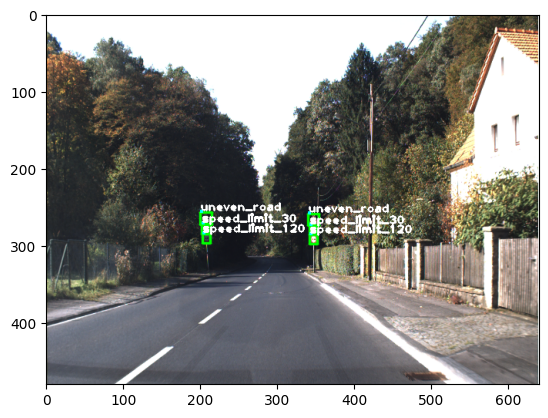

In [12]:
display_bbox(image.permute(1,2,0).cpu(), bbox.cpu(), classes_pred)

In [13]:
model = torchvision.models.resnet50(weights='IMAGENET1K_V2')

In [ ]:
required_layers = list(model.children())[:8]

In [ ]:
backbone = nn.Sequential(*required_layers)
backbone.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [ ]:
feature_maps = backbone(image_data_all)

In [ ]:
feature_maps.shape

torch.Size([2, 2048, 15, 20])

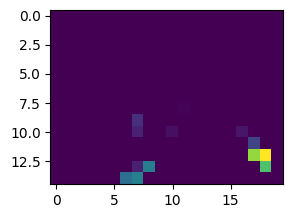

In [ ]:
feature = (feature_maps[0,0].detach()).cpu().numpy().astype(np.float32)
plt.figure(figsize=(3,5))
plt.imshow(feature)

In [ ]:
def gen_anc_centers(out_size):
    out_h, out_w = out_size
    
    anc_pts_x = torch.arange(0, out_w) + 0.5
    anc_pts_y = torch.arange(0, out_h) + 0.5
    
    return anc_pts_x.to(device), anc_pts_y.to(device)

In [ ]:
def gen_anc_base(anc_pts_x, anc_pts_y, anc_scales, anc_ratios, out_size):
    n_anc_boxes = len(anc_scales) * len(anc_ratios)
    anc_base = torch.zeros(1, anc_pts_x.size(dim=0) \
                              , anc_pts_y.size(dim=0), n_anc_boxes, 4).to(device) # shape - [1, Hmap, Wmap, n_anchor_boxes, 4]
    
    for ix, xc in enumerate(anc_pts_x):
        for jx, yc in enumerate(anc_pts_y):
            anc_boxes = torch.zeros((n_anc_boxes, 4))
            c = 0
            for i, scale in enumerate(anc_scales):
                for j, ratio in enumerate(anc_ratios):
                    w = scale * ratio
                    h = scale
                    
                    xmin = xc - w / 2
                    ymin = yc - h / 2
                    xmax = xc + w / 2
                    ymax = yc + h / 2

                    anc_boxes[c, :] = torch.Tensor([xmin, ymin, xmax, ymax])
                    c += 1

            anc_base[:, ix, jx, :] = ops.clip_boxes_to_image(anc_boxes, size=out_size).to(device)
            
    return anc_base.to(device)

In [ ]:
def project_bboxes(bboxes, width_scale_factor, height_scale_factor, mode='a2p'):
    assert mode in ['a2p', 'p2a']
    
    batch_size = bboxes.size(dim=0)
    proj_bboxes = bboxes.clone().reshape(batch_size, -1, 4)
    invalid_bbox_mask = (proj_bboxes == -1) # indicating padded bboxes
    
    if mode == 'a2p':
        # activation map to pixel image
        proj_bboxes[:, :, [0, 2]] *= width_scale_factor
        proj_bboxes[:, :, [1, 3]] *= height_scale_factor
    else:
        # pixel image to activation map
        proj_bboxes[:, :, [0, 2]] /= width_scale_factor
        proj_bboxes[:, :, [1, 3]] /= height_scale_factor
        
    proj_bboxes.masked_fill_(invalid_bbox_mask, -1) # fill padded bboxes back with -1
    proj_bboxes.resize_as_(bboxes)
    
    return proj_bboxes.to(device)

In [ ]:
def get_iou_mat(batch_size, anc_boxes_all, gt_bboxes_all):
    anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4).to(device)
    tot_anc_boxes = anc_boxes_flat.size(dim=1)
    ious_mat = torch.zeros((batch_size, tot_anc_boxes, gt_bboxes_all.size(dim=1))).to(device)
    for i in range(batch_size):
        gt_bboxes = gt_bboxes_all[i]
        anc_boxes = anc_boxes_flat[i]
        ious_mat[i, :] = ops.box_iou(anc_boxes, gt_bboxes)
        
    return ious_mat.to(device)

In [ ]:
def calc_gt_offsets(pos_anc_coords, gt_bbox_mapping):
    pos_anc_coords = ops.box_convert(pos_anc_coords, in_fmt='xyxy', out_fmt='cxcywh')
    gt_bbox_mapping = ops.box_convert(gt_bbox_mapping, in_fmt='xyxy', out_fmt='cxcywh')

    gt_cx, gt_cy, gt_w, gt_h = gt_bbox_mapping[:, 0], gt_bbox_mapping[:, 1], gt_bbox_mapping[:, 2], gt_bbox_mapping[:, 3]
    anc_cx, anc_cy, anc_w, anc_h = pos_anc_coords[:, 0], pos_anc_coords[:, 1], pos_anc_coords[:, 2], pos_anc_coords[:, 3]

    tx_ = (gt_cx - anc_cx)/anc_w
    ty_ = (gt_cy - anc_cy)/anc_h
    tw_ = torch.log(gt_w / anc_w)
    th_ = torch.log(gt_h / anc_h)

    return torch.stack([tx_, ty_, tw_, th_], dim=-1).to(device)

In [ ]:
pos_thresh=0.7
neg_thresh=0.2

In [ ]:
def get_req_anchors(anc_boxes_all, gt_bboxes_all, gt_classes_all, pos_thresh=0.7, neg_thresh=0.2):
    
    B, w_amap, h_amap, A, _ = anc_boxes_all.shape
    tot_anc_boxes = A * w_amap * h_amap
    iou_mat = get_iou_mat(B, anc_boxes_all, gt_bboxes_all)
    max_iou_per_gt_box, _ = iou_mat.max(dim=1, keepdim=True)
    positive_anc_mask = torch.logical_and(iou_mat == max_iou_per_gt_box, max_iou_per_gt_box > 0) .to(device)
    positive_anc_mask = torch.logical_or(positive_anc_mask, iou_mat > pos_thresh).to(device)
    
    positive_anc_ind_sep = torch.where(positive_anc_mask)[0].to(device)
    positive_anc_mask = positive_anc_mask.flatten(start_dim=0, end_dim=1).to(device)
    positive_anc_ind = torch.where(positive_anc_mask)[0].to(device)
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
    max_iou_per_anc = max_iou_per_anc.flatten(start_dim=0, end_dim=1).to(device)
    GT_conf_scores = max_iou_per_anc[positive_anc_ind].to(device)
    gt_classes_expand = gt_classes_all.view(B, 1, N).expand(B, tot_anc_boxes, N).to(device)
    GT_class = torch.gather(gt_classes_expand, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1).to(device)
    GT_class = GT_class.flatten(start_dim=0, end_dim=1).to(device)
    GT_class_pos = GT_class[positive_anc_ind].to(device)
    gt_bboxes_expand = gt_bboxes_all.view(B, 1, N, 4).expand(B, tot_anc_boxes, N, 4).to(device)
    GT_bboxes = torch.gather(gt_bboxes_expand, -2, max_iou_per_anc_ind.reshape(B, tot_anc_boxes, 1, 1).repeat(1, 1, 1, 4))
    GT_bboxes = GT_bboxes.flatten(start_dim=0, end_dim=2)
    GT_bboxes_pos = GT_bboxes[positive_anc_ind]
    anc_boxes_flat = anc_boxes_all.flatten(start_dim=0, end_dim=-2).to(device)
    positive_anc_coords = anc_boxes_flat[positive_anc_ind]
    GT_offsets = calc_gt_offsets(positive_anc_coords, GT_bboxes_pos).to(device)
    negative_anc_mask = (max_iou_per_anc < neg_thresh)
    negative_anc_ind = torch.where(negative_anc_mask)[0]
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (positive_anc_ind.shape[0],))]
    negative_anc_coords = anc_boxes_flat[negative_anc_ind]
    
    return positive_anc_ind.to(device), negative_anc_ind.to(device), GT_conf_scores.to(device), GT_offsets, GT_class_pos.to(device), \
         positive_anc_coords.to(device), negative_anc_coords.to(device), positive_anc_ind_sep.to(device)

In [ ]:
class ProposalModule(nn.Module):
    def __init__(self, in_features, hidden_dim=512, n_anchors=9, p_dropout=0.3):
        super().__init__()
        self.n_anchors = n_anchors
        self.conv1 = nn.Conv2d(in_features, hidden_dim, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p_dropout)
        self.conf_head = nn.Conv2d(hidden_dim, n_anchors, kernel_size=1)
        self.reg_head = nn.Conv2d(hidden_dim, n_anchors * 4, kernel_size=1)
        
    def forward(self, feature_map, pos_anc_ind=None, neg_anc_ind=None, pos_anc_coords=None):
        if pos_anc_ind is None or neg_anc_ind is None or pos_anc_coords is None:
            mode = 'eval'
        else:
            mode = 'train'
            
        out = self.conv1(feature_map)
        out = F.relu(self.dropout(out))
        
        reg_offsets_pred = self.reg_head(out) # (B, A*4, hmap, wmap)
        conf_scores_pred = self.conf_head(out) # (B, A, hmap, wmap)
        
        if mode == 'train': 
            conf_scores_pos = conf_scores_pred.flatten()[pos_anc_ind]
            conf_scores_neg = conf_scores_pred.flatten()[neg_anc_ind]
            offsets_pos = reg_offsets_pred.contiguous().view(-1, 4)[pos_anc_ind]
            proposals = generate_proposals(pos_anc_coords, offsets_pos)
            
            return conf_scores_pos, conf_scores_neg, offsets_pos, proposals
            
        elif mode == 'eval':
            return conf_scores_pred, reg_offsets_pred

In [ ]:
def generate_proposals(anchors, offsets):
    anchors = ops.box_convert(anchors, in_fmt='xyxy', out_fmt='cxcywh').to(device)
    proposals_ = torch.zeros_like(anchors).to(device)
    proposals_[:,0] = (anchors[:,0] + offsets[:,0]*anchors[:,2]).to(device)
    proposals_[:,1] = (anchors[:,1] + offsets[:,1]*anchors[:,3]).to(device)
    proposals_[:,2] = (anchors[:,2] * torch.exp(offsets[:,2])).to(device)
    proposals_[:,3] = (anchors[:,3] * torch.exp(offsets[:,3])).to(device)
    proposals = ops.box_convert(proposals_, in_fmt='cxcywh', out_fmt='xyxy')

    return proposals.to(device)

In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, out_size, out_channels):
        super().__init__()
        
        self.img_height, self.img_width = img_size
        self.out_h, self.out_w = out_size
        self.width_scale_factor = self.img_width // self.out_w
        self.height_scale_factor = self.img_height // self.out_h 
        self.anc_scales = [2, 4, 6]
        self.anc_ratios = [0.5, 1, 1.5]
        self.n_anc_boxes = len(self.anc_scales) * len(self.anc_ratios)
        self.pos_thresh = 0.7
        self.neg_thresh = 0.3
        
        self.w_conf = 1
        self.w_reg = 5
        
        self.feature_extractor = backbone.to(device)
        self.proposal_module = ProposalModule(out_channels, n_anchors=self.n_anc_boxes)
        
    def forward(self, images, gt_bboxes, gt_classes):
        batch_size = images.size(dim=0)
        feature_map = self.feature_extractor(images)
        anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
        anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
        anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1).to(device)
        
        gt_bboxes_proj = project_bboxes(gt_bboxes, self.width_scale_factor, self.height_scale_factor, mode='p2a')
        
        positive_anc_ind, negative_anc_ind, GT_conf_scores, \
        GT_offsets, GT_class_pos, positive_anc_coords, \
        negative_anc_coords, positive_anc_ind_sep = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes)

        conf_scores_pos, conf_scores_neg, offsets_pos, proposals = self.proposal_module(feature_map, positive_anc_ind, \
                                                                                        negative_anc_ind, positive_anc_coords)
        
        cls_loss = calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size)
        reg_loss = calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size)
        
        total_rpn_loss = self.w_conf * cls_loss + self.w_reg * reg_loss
        
        return total_rpn_loss, feature_map, proposals, positive_anc_ind_sep, GT_class_pos
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        with torch.no_grad():
            batch_size = images.size(dim=0)
            feature_map = self.feature_extractor(images)
            anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(self.out_h, self.out_w))
            anc_base = gen_anc_base(anc_pts_x, anc_pts_y, self.anc_scales, self.anc_ratios, (self.out_h, self.out_w))
            anc_boxes_all = anc_base.repeat(batch_size, 1, 1, 1, 1)
            anc_boxes_flat = anc_boxes_all.reshape(batch_size, -1, 4)
            conf_scores_pred, offsets_pred = self.proposal_module(feature_map)
            conf_scores_pred = conf_scores_pred.reshape(batch_size, -1).to(device)
            offsets_pred = offsets_pred.reshape(batch_size, -1, 4).to(device)

            proposals_final = []
            conf_scores_final = []
            for i in range(batch_size):
                conf_scores = torch.sigmoid(conf_scores_pred[i])
                offsets = offsets_pred[i]
                anc_boxes = anc_boxes_flat[i]
                proposals = generate_proposals(anc_boxes, offsets)
                conf_idx = torch.where(conf_scores >= conf_thresh)[0]
                conf_scores_pos = conf_scores[conf_idx]
                proposals_pos = proposals[conf_idx]
                nms_idx = ops.nms(proposals_pos, conf_scores_pos, nms_thresh)
                conf_scores_pos = conf_scores_pos[nms_idx]
                proposals_pos = proposals_pos[nms_idx]

                proposals_final.append(proposals_pos)
                conf_scores_final.append(conf_scores_pos)
            
        return proposals_final, conf_scores_final, feature_map

In [ ]:
class ClassificationModule(nn.Module):
    def __init__(self, out_channels, n_classes, roi_size, hidden_dim=512, p_dropout=0.3):
        super().__init__()        
        self.roi_size = roi_size
        self.avg_pool = nn.AvgPool2d(self.roi_size)
        self.fc = nn.Linear(out_channels, hidden_dim)
        self.dropout = nn.Dropout(p_dropout)

        self.cls_head = nn.Linear(hidden_dim, n_classes)
        
    def forward(self, feature_map, proposals_list, gt_classes=None):
        
        if gt_classes is None:
            mode = 'eval'
        else:
            mode = 'train'
        
        roi_out = ops.roi_pool(feature_map, proposals_list, self.roi_size)
        roi_out = self.avg_pool(roi_out)

        roi_out = roi_out.squeeze(-1).squeeze(-1)

        out = self.fc(roi_out)
        out = F.relu(self.dropout(out))
        cls_scores = self.cls_head(out)
        if mode == 'eval':
            return cls_scores
        cls_loss = F.cross_entropy(cls_scores, gt_classes.long())
        
        return cls_loss.to(device)

In [ ]:
class TwoStageDetector(nn.Module):
    def __init__(self, img_size, out_size, out_channels, n_classes, roi_size):
        super().__init__() 
        self.rpn = RegionProposalNetwork(img_size, out_size, out_channels)
        self.classifier = ClassificationModule(out_channels, n_classes, roi_size)
        
    def forward(self, images, gt_bboxes, gt_classes):
        total_rpn_loss, feature_map, proposals, \
        positive_anc_ind_sep, GT_class_pos = self.rpn(images, gt_bboxes, gt_classes)

        pos_proposals_list = []
        batch_size = images.size(dim=0)
        for idx in range(batch_size):
            proposal_idxs = torch.where(positive_anc_ind_sep == idx)[0]
            proposals_sep = proposals[proposal_idxs].detach().clone()
            pos_proposals_list.append(proposals_sep)
        
        cls_loss = self.classifier(feature_map, pos_proposals_list, GT_class_pos)
        total_loss = cls_loss + total_rpn_loss
        
        return total_loss
    
    def inference(self, images, conf_thresh=0.5, nms_thresh=0.7):
        batch_size = images.size(dim=0)
        proposals_final, conf_scores_final, feature_map = self.rpn.inference(images, conf_thresh, nms_thresh)
        cls_scores = self.classifier(feature_map, proposals_final)

        cls_probs = F.softmax(cls_scores, dim=-1)
        classes_all = torch.argmax(cls_probs, dim=-1)
        
        classes_final = []
        c = 0
        for i in range(batch_size):
            n_proposals = len(proposals_final[i])
            classes_final.append(classes_all[c: c+n_proposals])
            c += n_proposals
            
        return proposals_final, conf_scores_final, classes_final

In [ ]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    loss_list = []
    
    for i in tqdm(range(n_epochs)):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in train_dataloader:
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        loss_list.append(total_loss)
        
    return loss_list

In [ ]:
img_height = 480
img_width = 640
out_h = 15
out_w = 20
out_c = 2048
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = 43
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size)

In [ ]:
def calc_cls_loss(conf_scores_pos, conf_scores_neg, batch_size):
    
    conf_scores = torch.cat([conf_scores_pos, conf_scores_neg], dim=0)
    targets = torch.cat([torch.ones_like(conf_scores_pos), torch.zeros_like(conf_scores_neg)], dim=0)
    loss = F.binary_cross_entropy_with_logits(conf_scores, targets)
    return loss * batch_size

def calc_bbox_reg_loss(GT_offsets, offsets_pos, batch_size):
    loss = F.smooth_l1_loss(offsets_pos, GT_offsets, reduction='sum')
    return loss / batch_size

In [ ]:
learning_rate = 1e-3
n_epochs = 1

loss_list = training_loop(detector, learning_rate, train_loader, n_epochs)

100%|██████████| 1/1 [02:28<00:00, 148.71s/it]


In [ ]:
detector.eval()
image,_,_ = dataset[10:13]
print(image.shape)
proposals_final, conf_scores_final, classes_final = detector.inference(image, conf_thresh=0.99, nms_thresh=0.05)

torch.Size([3, 3, 480, 640])


In [ ]:
proposals_final

[tensor([[-0.0534, -0.0746, -0.0522, -0.0727]], device='cuda:0'),
 tensor([[-0.0501, -0.0814, -0.0489, -0.0795]], device='cuda:0'),
 tensor([[-0.0471, -0.0728, -0.0459, -0.0708]], device='cuda:0')]

In [ ]:
conf_scores_final

[tensor([0.9962], device='cuda:0'),
 tensor([0.9959], device='cuda:0'),
 tensor([0.9959], device='cuda:0')]

In [ ]:
classes_final

[tensor([12], device='cuda:0'),
 tensor([12], device='cuda:0'),
 tensor([12], device='cuda:0')]

In [ ]:
prop_proj_1 = project_bboxes(proposals_final[0], 32, 32, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], 32, 32, mode='a2p')
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

In [ ]:
classes_pred_1

In [ ]:
display_bbox(image_data_all[0].cpu().permute(1,2,0), prop_proj_1.cpu(), classes_pred_1)